# Game Prediction using Logistic Regression
## An analysis with Chess Match Statistics
## Jessica Erasmus

Logistic regression is a statistical modelling technique used to make binary and multi-class predictions in a variety of fields, such as the gaming industry. It is especially well-suited for predicting game outcomes because it enables users to understand the relationship between one or more independent variables and the likelihood of a specific event occurring. In the context of gaming, these events can range from the likelihood of a team winning a match to the likelihood of a player reaching a specific in-game milestone.

The prediction of games outcomes has become an intriguing topic in the ever-evolving context of data science and the gaming industry. Game prediction has sparked the interest of both players and stakeholders in the gaming environment, whether it's predicting the winner of a competitive esports’ tournament, anticipating the success of a new video game release, or estimating the likelihood of a specific in-game event occurring.

For this analysis, a prediction model is built to determine which player will win a chess match using logistic regression. The model predicts the likelihood of the player using white chess pieces’ chances of winning based on both players’ Elo rating and player white’s difference in ranking from player black.

In [76]:
#import pyspark
import pyspark
from pyspark.context import SparkContext
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [77]:
# Import findspark
import findspark
findspark.init()

In [78]:
import warnings
warnings.filterwarnings("ignore")

In [79]:
# Create Spark session
spark = SparkSession.builder.appName("Logistic Regression for App Popularity").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","3g").getOrCreate()

### Loading the data

In [80]:
# Create DataFrame
# https://www.kaggle.com/datasets/sahit2509/chess-dataset-100000-games-lichess
df = spark.read.csv('data/sep.csv', header=True, inferSchema = True)
df.show()

+---+--------------------+----------+-----+-----------------+--------------------+-------+--------+---+--------------------+------------+-----------+--------+---------------+
|_c0|               Event|      Date|Round|            White|               Black| Result|BlackElo|ECO|             Opening| Termination|TimeControl|WhiteElo|WhiteRatingDiff|
+---+--------------------+----------+-----+-----------------+--------------------+-------+--------+---+--------------------+------------+-----------+--------+---------------+
|  0|Rated Blitz tourn...|2020.09.01|    -|    AttackSparrow|            danicuva|    1-0|    2218|C00|French Defense: S...|Time forfeit|      180+0|    2460|              2|
|  1|    Rated Blitz game|2020.09.01|    -|       onthewaygm|        starkspieler|    1-0|    2424|E90|King's Indian Def...|      Normal|      180+0|    2428|              6|
|  2|Rated Rapid tourn...|2020.09.01|    -|         OjaiJoao|    FitzwilliamDarcy|    1-0|    2300|B06|Modern Defense: S...| 

In [81]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Event: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Round: string (nullable = true)
 |-- White: string (nullable = true)
 |-- Black: string (nullable = true)
 |-- Result: string (nullable = true)
 |-- BlackElo: integer (nullable = true)
 |-- ECO: string (nullable = true)
 |-- Opening: string (nullable = true)
 |-- Termination: string (nullable = true)
 |-- TimeControl: string (nullable = true)
 |-- WhiteElo: integer (nullable = true)
 |-- WhiteRatingDiff: integer (nullable = true)



In [82]:
import pandas as pd

pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
_c0,0,1,2,3,4
Event,Rated Blitz tournament https://lichess.org/tou...,Rated Blitz game,Rated Rapid tournament https://lichess.org/tou...,Rated Blitz tournament https://lichess.org/tou...,Rated Blitz game
Date,2020.09.01,2020.09.01,2020.09.01,2020.09.01,2020.09.01
Round,-,-,-,-,-
White,AttackSparrow,onthewaygm,OjaiJoao,WenceslaoRodrigo,HoldenHc
Black,danicuva,starkspieler,FitzwilliamDarcy,zonrobla,gg-gm-gmg
Result,1-0,1-0,1-0,0-1,1-0
BlackElo,2218,2424,2300,2667,2682
ECO,C00,E90,B06,E71,A41
Opening,French Defense: Schlechter Variation,"King's Indian Defense: Normal Variation, Rare ...",Modern Defense: Standard Defense,King's Indian Defense: Makogonov Variation,Queen's Pawn


In [83]:
len(df.columns)

14

In [84]:
df.count()

99913

The intial dataset has 99913 rows and 14 columns

### Data Cleaning
Unclean data can result in inaccurate opinions and assumptions about data-driven insights, poorly constructed decisions based on those insights, and a general misunderstanding of the analytical process. It may also negatively affect tasks that depend on accurate execution of clean data.
For this section we drop unnecessary data and clarify the winner for each match

In [85]:
# Count the number of null values in each column
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+-----+----+-----+-----+-----+------+--------+---+-------+-----------+-----------+--------+---------------+
|_c0|Event|Date|Round|White|Black|Result|BlackElo|ECO|Opening|Termination|TimeControl|WhiteElo|WhiteRatingDiff|
+---+-----+----+-----+-----+-----+------+--------+---+-------+-----------+-----------+--------+---------------+
|  0|    0|   0|    0|    0|    0|     0|       0|  0|      0|          0|          0|       0|              0|
+---+-----+----+-----+-----+-----+------+--------+---+-------+-----------+-----------+--------+---------------+



In [86]:
# The unnamed and Round columns are repetitive and do not provide much information, hence the columns are dropped
df = df.drop('_c0', 'Round')

In [87]:
df = df.withColumn('Winner', when(df['Result'] == '1-0', 'White').when(df['Result'] == '0-1', 'Black').otherwise('Draw'))

In [88]:
# Print shape of dataframe
print((df.count(), len(df.columns)))

(99913, 13)


In [89]:
df.printSchema()

root
 |-- Event: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- White: string (nullable = true)
 |-- Black: string (nullable = true)
 |-- Result: string (nullable = true)
 |-- BlackElo: integer (nullable = true)
 |-- ECO: string (nullable = true)
 |-- Opening: string (nullable = true)
 |-- Termination: string (nullable = true)
 |-- TimeControl: string (nullable = true)
 |-- WhiteElo: integer (nullable = true)
 |-- WhiteRatingDiff: integer (nullable = true)
 |-- Winner: string (nullable = false)



In [90]:
df.show()

+--------------------+----------+-----------------+--------------------+-------+--------+---+--------------------+------------+-----------+--------+---------------+------+
|               Event|      Date|            White|               Black| Result|BlackElo|ECO|             Opening| Termination|TimeControl|WhiteElo|WhiteRatingDiff|Winner|
+--------------------+----------+-----------------+--------------------+-------+--------+---+--------------------+------------+-----------+--------+---------------+------+
|Rated Blitz tourn...|2020.09.01|    AttackSparrow|            danicuva|    1-0|    2218|C00|French Defense: S...|Time forfeit|      180+0|    2460|              2| White|
|    Rated Blitz game|2020.09.01|       onthewaygm|        starkspieler|    1-0|    2424|E90|King's Indian Def...|      Normal|      180+0|    2428|              6| White|
|Rated Rapid tourn...|2020.09.01|         OjaiJoao|    FitzwilliamDarcy|    1-0|    2300|B06|Modern Defense: S...|      Normal|      600+5| 

### Exploratory Data Analysis

In [91]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
Event,Rated Blitz tournament https://lichess.org/tou...,Rated Blitz game,Rated Rapid tournament https://lichess.org/tou...,Rated Blitz tournament https://lichess.org/tou...,Rated Blitz game
Date,2020.09.01,2020.09.01,2020.09.01,2020.09.01,2020.09.01
White,AttackSparrow,onthewaygm,OjaiJoao,WenceslaoRodrigo,HoldenHc
Black,danicuva,starkspieler,FitzwilliamDarcy,zonrobla,gg-gm-gmg
Result,1-0,1-0,1-0,0-1,1-0
BlackElo,2218,2424,2300,2667,2682
ECO,C00,E90,B06,E71,A41
Opening,French Defense: Schlechter Variation,"King's Indian Defense: Normal Variation, Rare ...",Modern Defense: Standard Defense,King's Indian Defense: Makogonov Variation,Queen's Pawn
Termination,Time forfeit,Normal,Normal,Normal,Normal
TimeControl,180+0,180+0,600+5,180+1,180+0


In [93]:
# Describe the Spark DataFrame
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
BlackElo,99913,2443.3011620109496,99.56966156291874,2200,2988
WhiteElo,99913,2443.180897380721,99.4675319877633,2200,2986
WhiteRatingDiff,99913,0.3830832824557365,6.667514224211187,-152,233


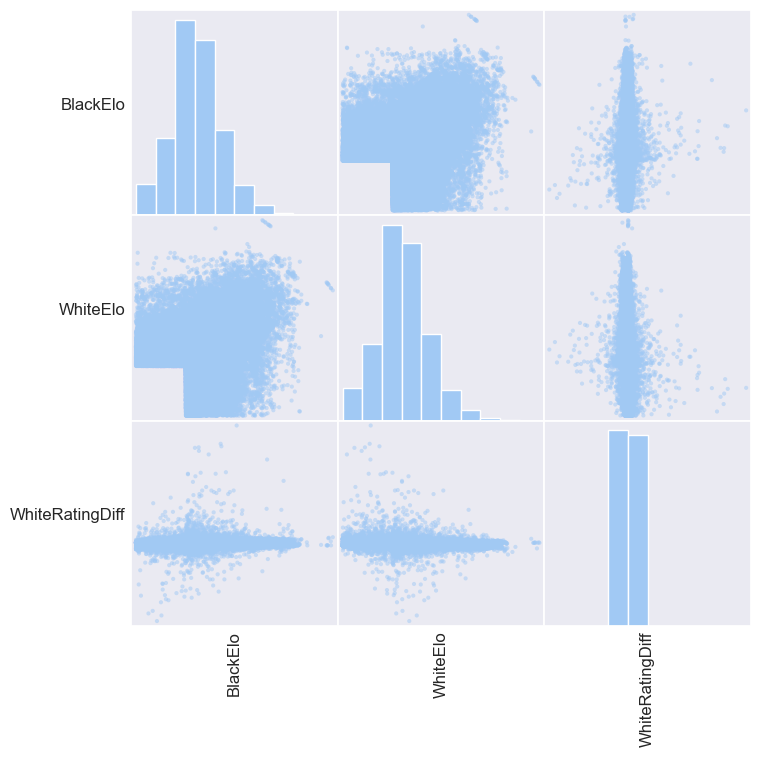

In [94]:
numeric_data = df.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)

for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [116]:
# Find the minimum value of a column
df.agg(F.min('WhiteElo')).show()

+-------------+
|min(WhiteElo)|
+-------------+
|         2200|
+-------------+



In [117]:
# Find the maximum value of a column
df.agg(F.max('WhiteElo')).show()

+-------------+
|max(WhiteElo)|
+-------------+
|         2986|
+-------------+



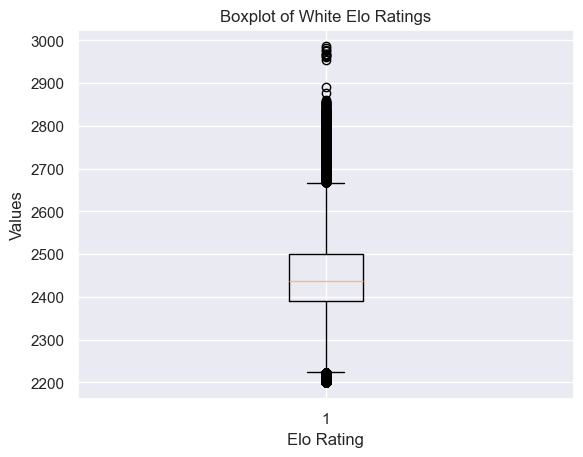

In [115]:
# Create a new DataFrame with the column you want to plot
column_df = df.select('WhiteElo')

# Create a boxplot of the column
plt.boxplot(column_df.toPandas())

# Add labels and title to the plot
plt.xlabel('Elo Rating')
plt.ylabel('Values')
plt.title('Boxplot of White Elo Ratings')

# Display the plot
plt.show()

In [119]:
# Find the minimum value of a column
df.agg(F.min('BlackElo')).show()

+-------------+
|min(BlackElo)|
+-------------+
|         2200|
+-------------+



In [120]:
# Find the maximum value of a column
df.agg(F.max('BlackElo')).show()

+-------------+
|max(BlackElo)|
+-------------+
|         2988|
+-------------+



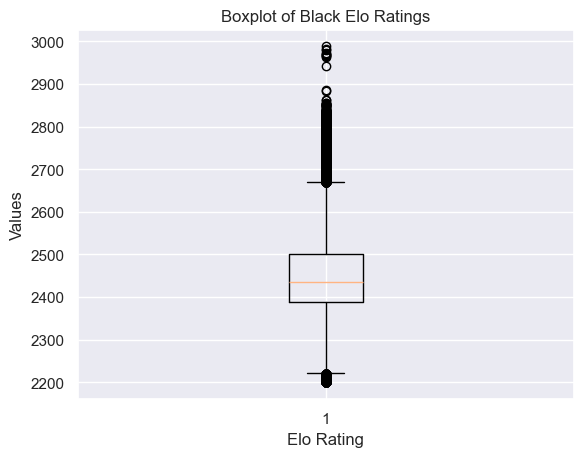

In [118]:
# Create a new DataFrame with the column you want to plot
column_df = df.select('BlackElo')

# Create a boxplot of the column
plt.boxplot(column_df.toPandas())

# Add labels and title to the plot
plt.xlabel('Elo Rating')
plt.ylabel('Values')
plt.title('Boxplot of Black Elo Ratings')

# Display the plot
plt.show()

Black and White Elo scores have similar correlations to the Rating Difference of White. Black and White Elo Ratings also show similar statistic results.

Next, the counts of certain data values are reviewed.

In [95]:
# Group by 'Event' and 'Date' columns and count the number of occurrences
counts = df.groupby(['Event', 'Date']).count()
counts.show()

+--------------------+----------+-----+
|               Event|      Date|count|
+--------------------+----------+-----+
|Rated Blitz tourn...|2020.09.01|   11|
|Rated Blitz tourn...|2020.09.02|    4|
|Rated Blitz tourn...|2020.09.02|    7|
|Rated Blitz tourn...|2020.09.03|    5|
|Rated Rapid tourn...|2020.09.01|    2|
|Rated Blitz tourn...|2020.09.02|    1|
|Rated Blitz tourn...|2020.09.03|    1|
|Rated Blitz tourn...|2020.09.01|    2|
|Rated Rapid tourn...|2020.09.02|    2|
|Rated Blitz tourn...|2020.09.03|   77|
|Rated Blitz tourn...|2020.09.02|   16|
|Rated Blitz tourn...|2020.09.03|   25|
|Rated Blitz tourn...|2020.09.03|    4|
|Rated Blitz tourn...|2020.09.01|   72|
|Rated Blitz tourn...|2020.09.03|   43|
|Rated Blitz tourn...|2020.09.02|    8|
|Rated Blitz tourn...|2020.09.02|    1|
|Rated Blitz tourn...|2020.09.01|    3|
|Rated Blitz tourn...|2020.09.02|    4|
|Rated Blitz tourn...|2020.09.01|    2|
+--------------------+----------+-----+
only showing top 20 rows



In [96]:
# Count the number of occurrences of each unique value in the 'Opening' column
opening_counts = df.groupBy('Opening').count()
opening_counts.show()

+--------------------+-----+
|             Opening|count|
+--------------------+-----+
|Ruy Lopez: Classi...|    3|
|Slav Defense: Cze...|   18|
|Alekhine Defense:...|   20|
|King's Indian Att...|   95|
|Grünfeld Defense:...|  178|
|Tarrasch Defense:...|    6|
|Caro-Kann Defense...|   17|
|Italian Game: Two...|    1|
|Queen's Gambit Ac...|   34|
|Queen's Gambit De...|    5|
|King's Indian Def...|    4|
|King's Gambit, Fa...|    3|
|Four Knights Game...|   11|
|Owen Defense: Mat...|   14|
|Blackmar-Diemer G...|    2|
|French Defense: S...|  182|
|Grünfeld Defense:...|   19|
|King's Indian Def...|   29|
|French Defense: C...|  204|
|Grünfeld Defense:...|    8|
+--------------------+-----+
only showing top 20 rows



In [97]:
# Create a new DataFrame with the top 10 most frequently occurring openings
top10_openings = opening_counts.orderBy(desc('count')).limit(10)
top10_openings.show()

+--------------------+-----+
|             Opening|count|
+--------------------+-----+
|         Indian Game| 1710|
|      Modern Defense| 1129|
|   Trompowsky Attack| 1078|
|        Pirc Defense|  946|
|King's Indian Attack|  867|
|        Réti Opening|  796|
|     Horwitz Defense|  769|
|Queen's Pawn Game...|  746|
|Sicilian Defense:...|  688|
|Sicilian Defense:...|  683|
+--------------------+-----+



In [98]:
# import visualisation libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Text(0.5, 1.0, 'Most popular Openings played in September 2020')

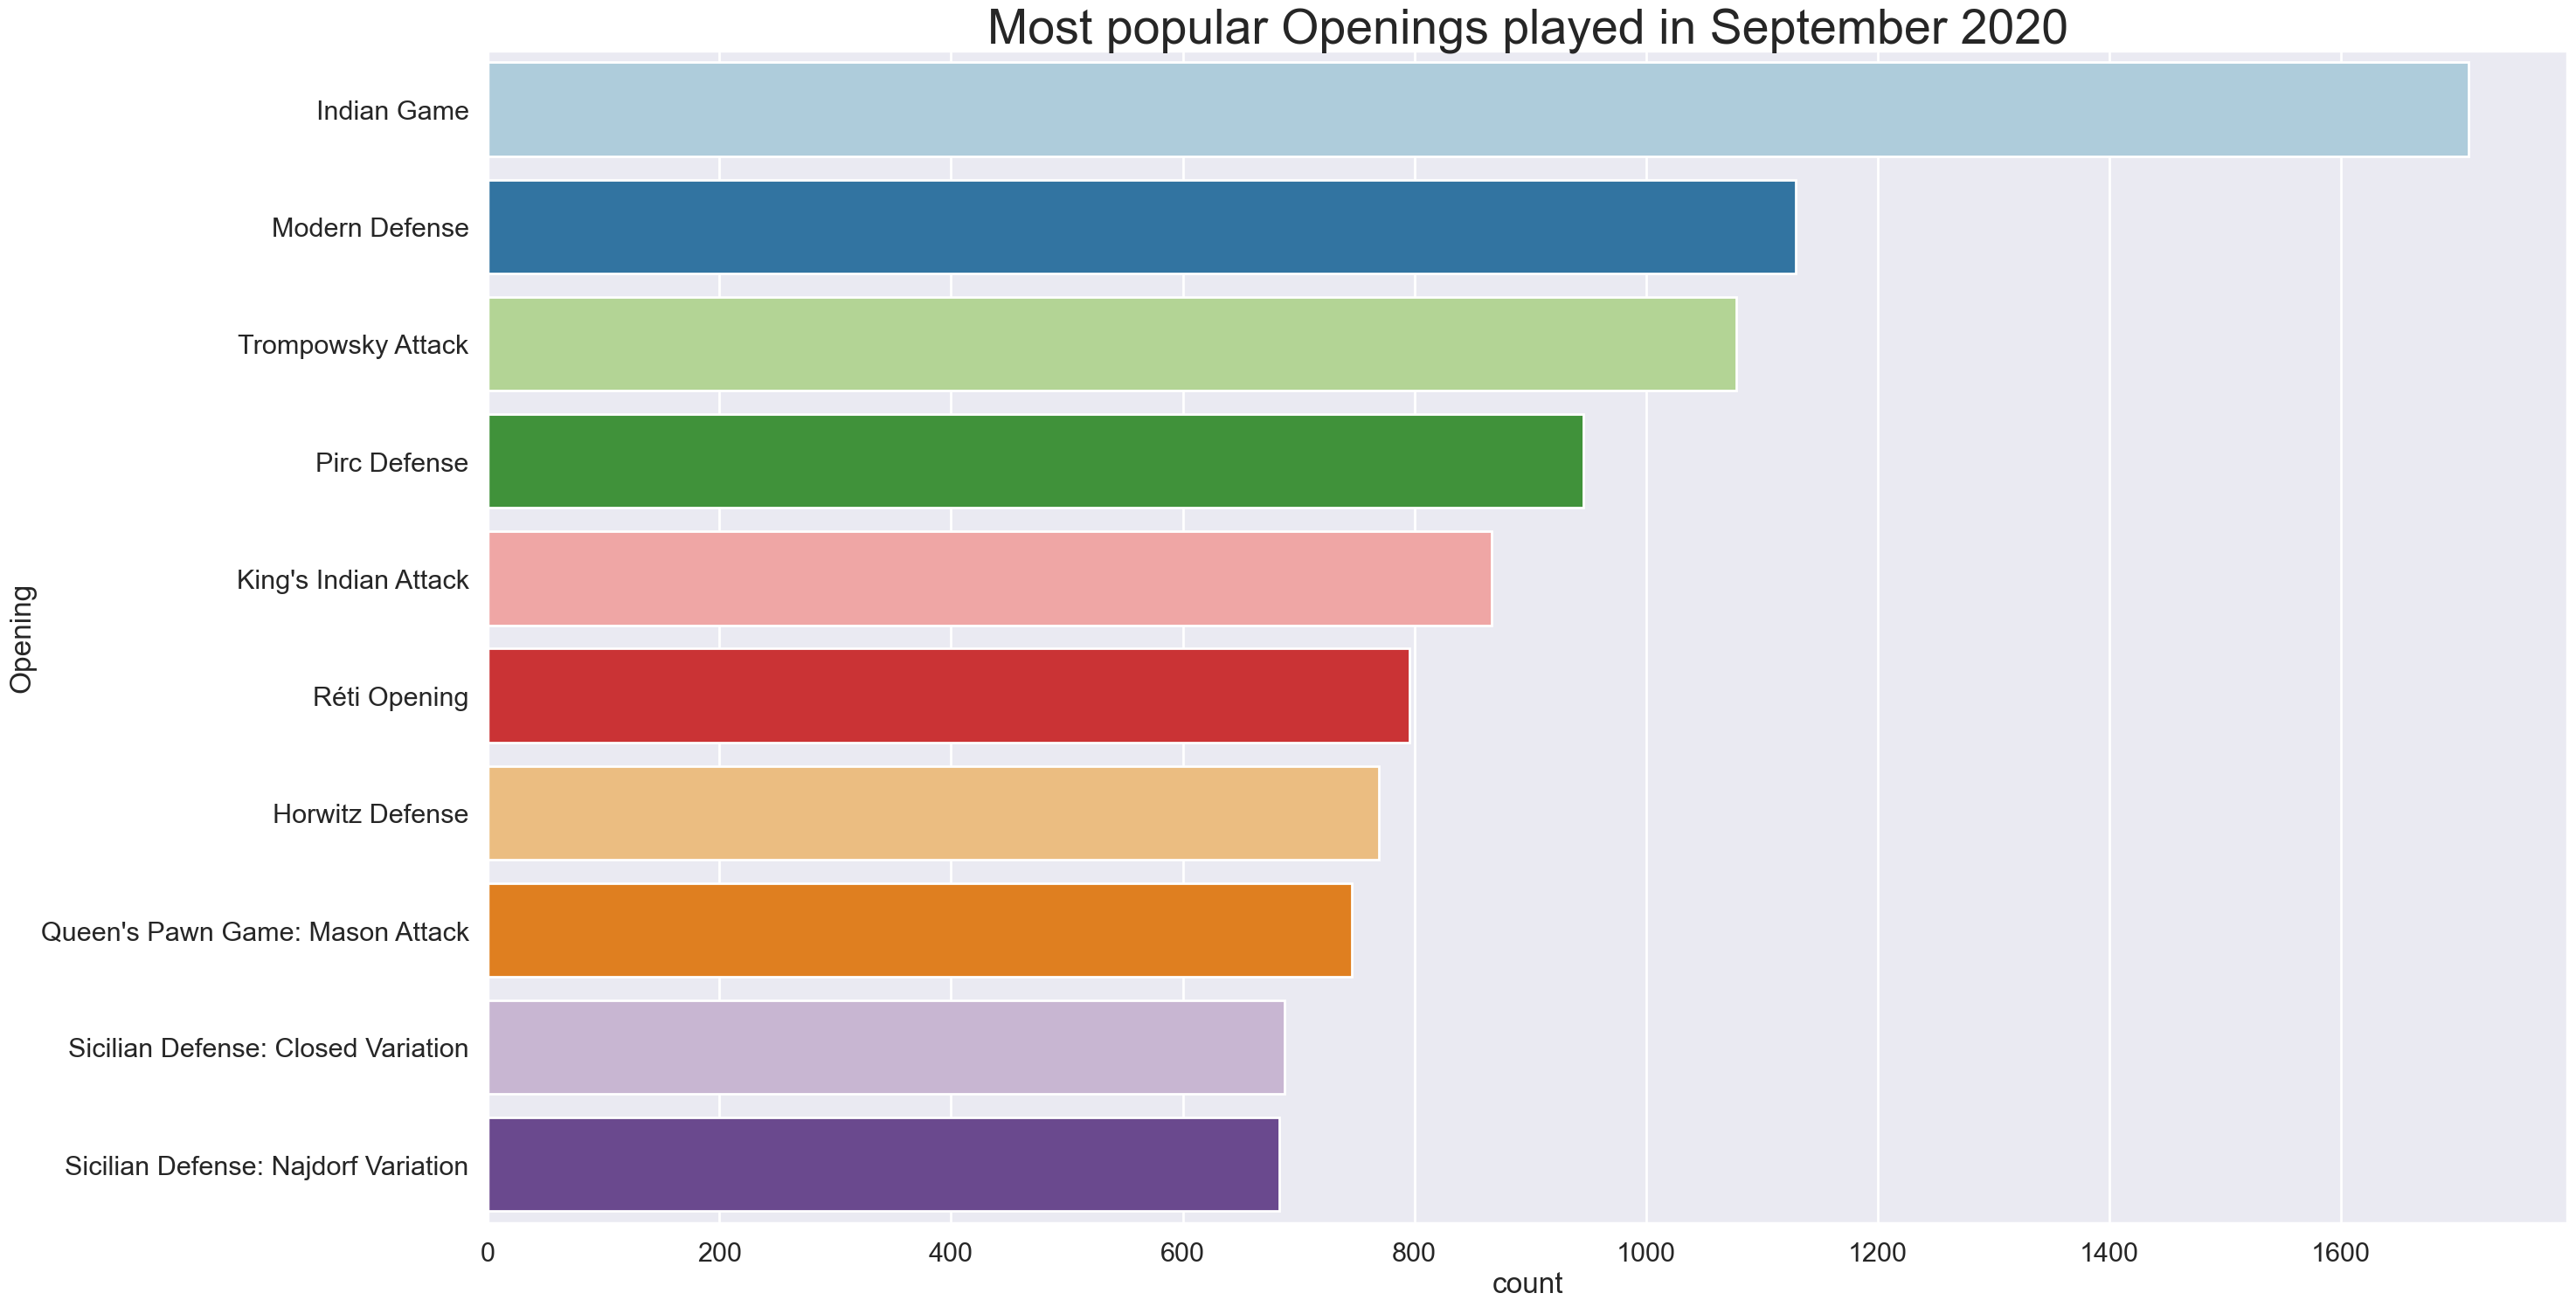

In [99]:
plt.figure(figsize=(30,15))
sns.set_context('poster',font_scale=1)
sns.set_palette('Paired')
sns.barplot(y="Opening",x="count", data=top10_openings.toPandas())
plt.tight_layout()
plt.title("Most popular Openings played in September 2020", fontsize=40)

Text(0.5, 1.0, 'Most popular Openings played in Blitz (Sep-2020)')

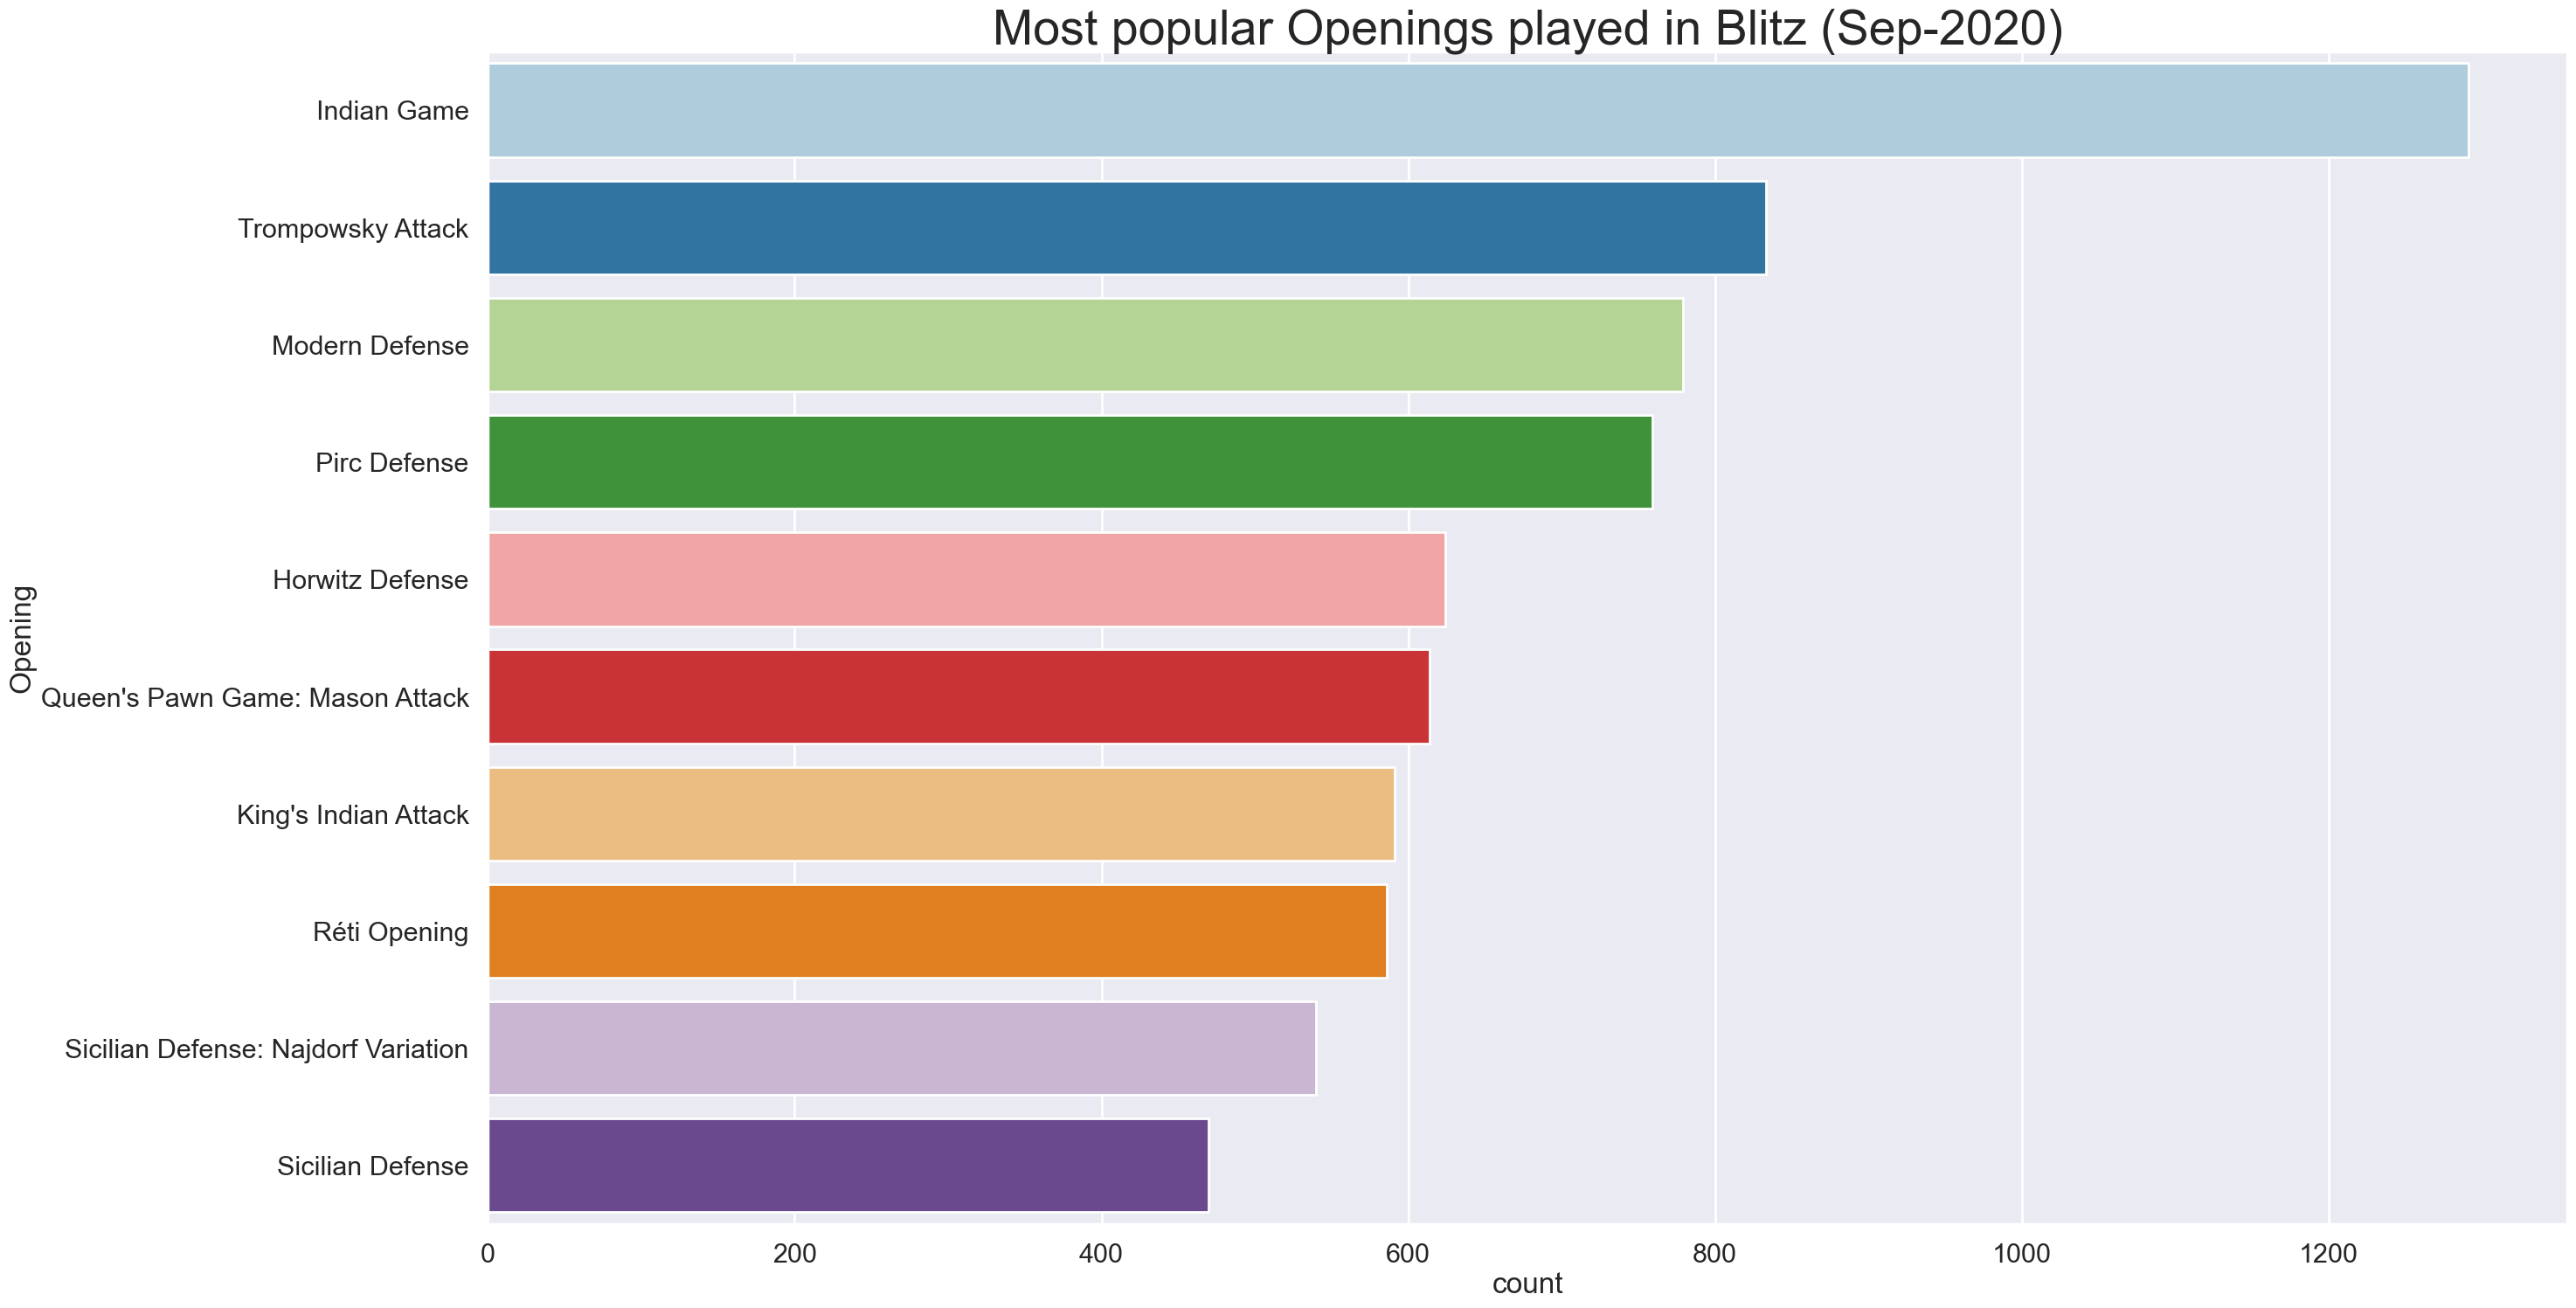

In [100]:
# Create a new DataFrame with the top 10 most frequently occurring openings in blitz games
top10_blitz_openings = df.filter(df['Event'] == 'Rated Blitz game').groupBy('Opening').count().orderBy(desc('count')).limit(10)

# Create a bar plot of the top 10 most frequently occurring openings in blitz games
blitz10 = top10_blitz_openings.toPandas()
plt.figure(figsize=(30,15))
sns.barplot(y="Opening",x="count", data=blitz10)
sns.set_context('poster',font_scale=1)
plt.tight_layout()
plt.title("Most popular Openings played in Blitz (Sep-2020)", fontsize=40)

Text(0.5, 1.0, 'Most popular Openings played in Rapid (Sep-2020)')

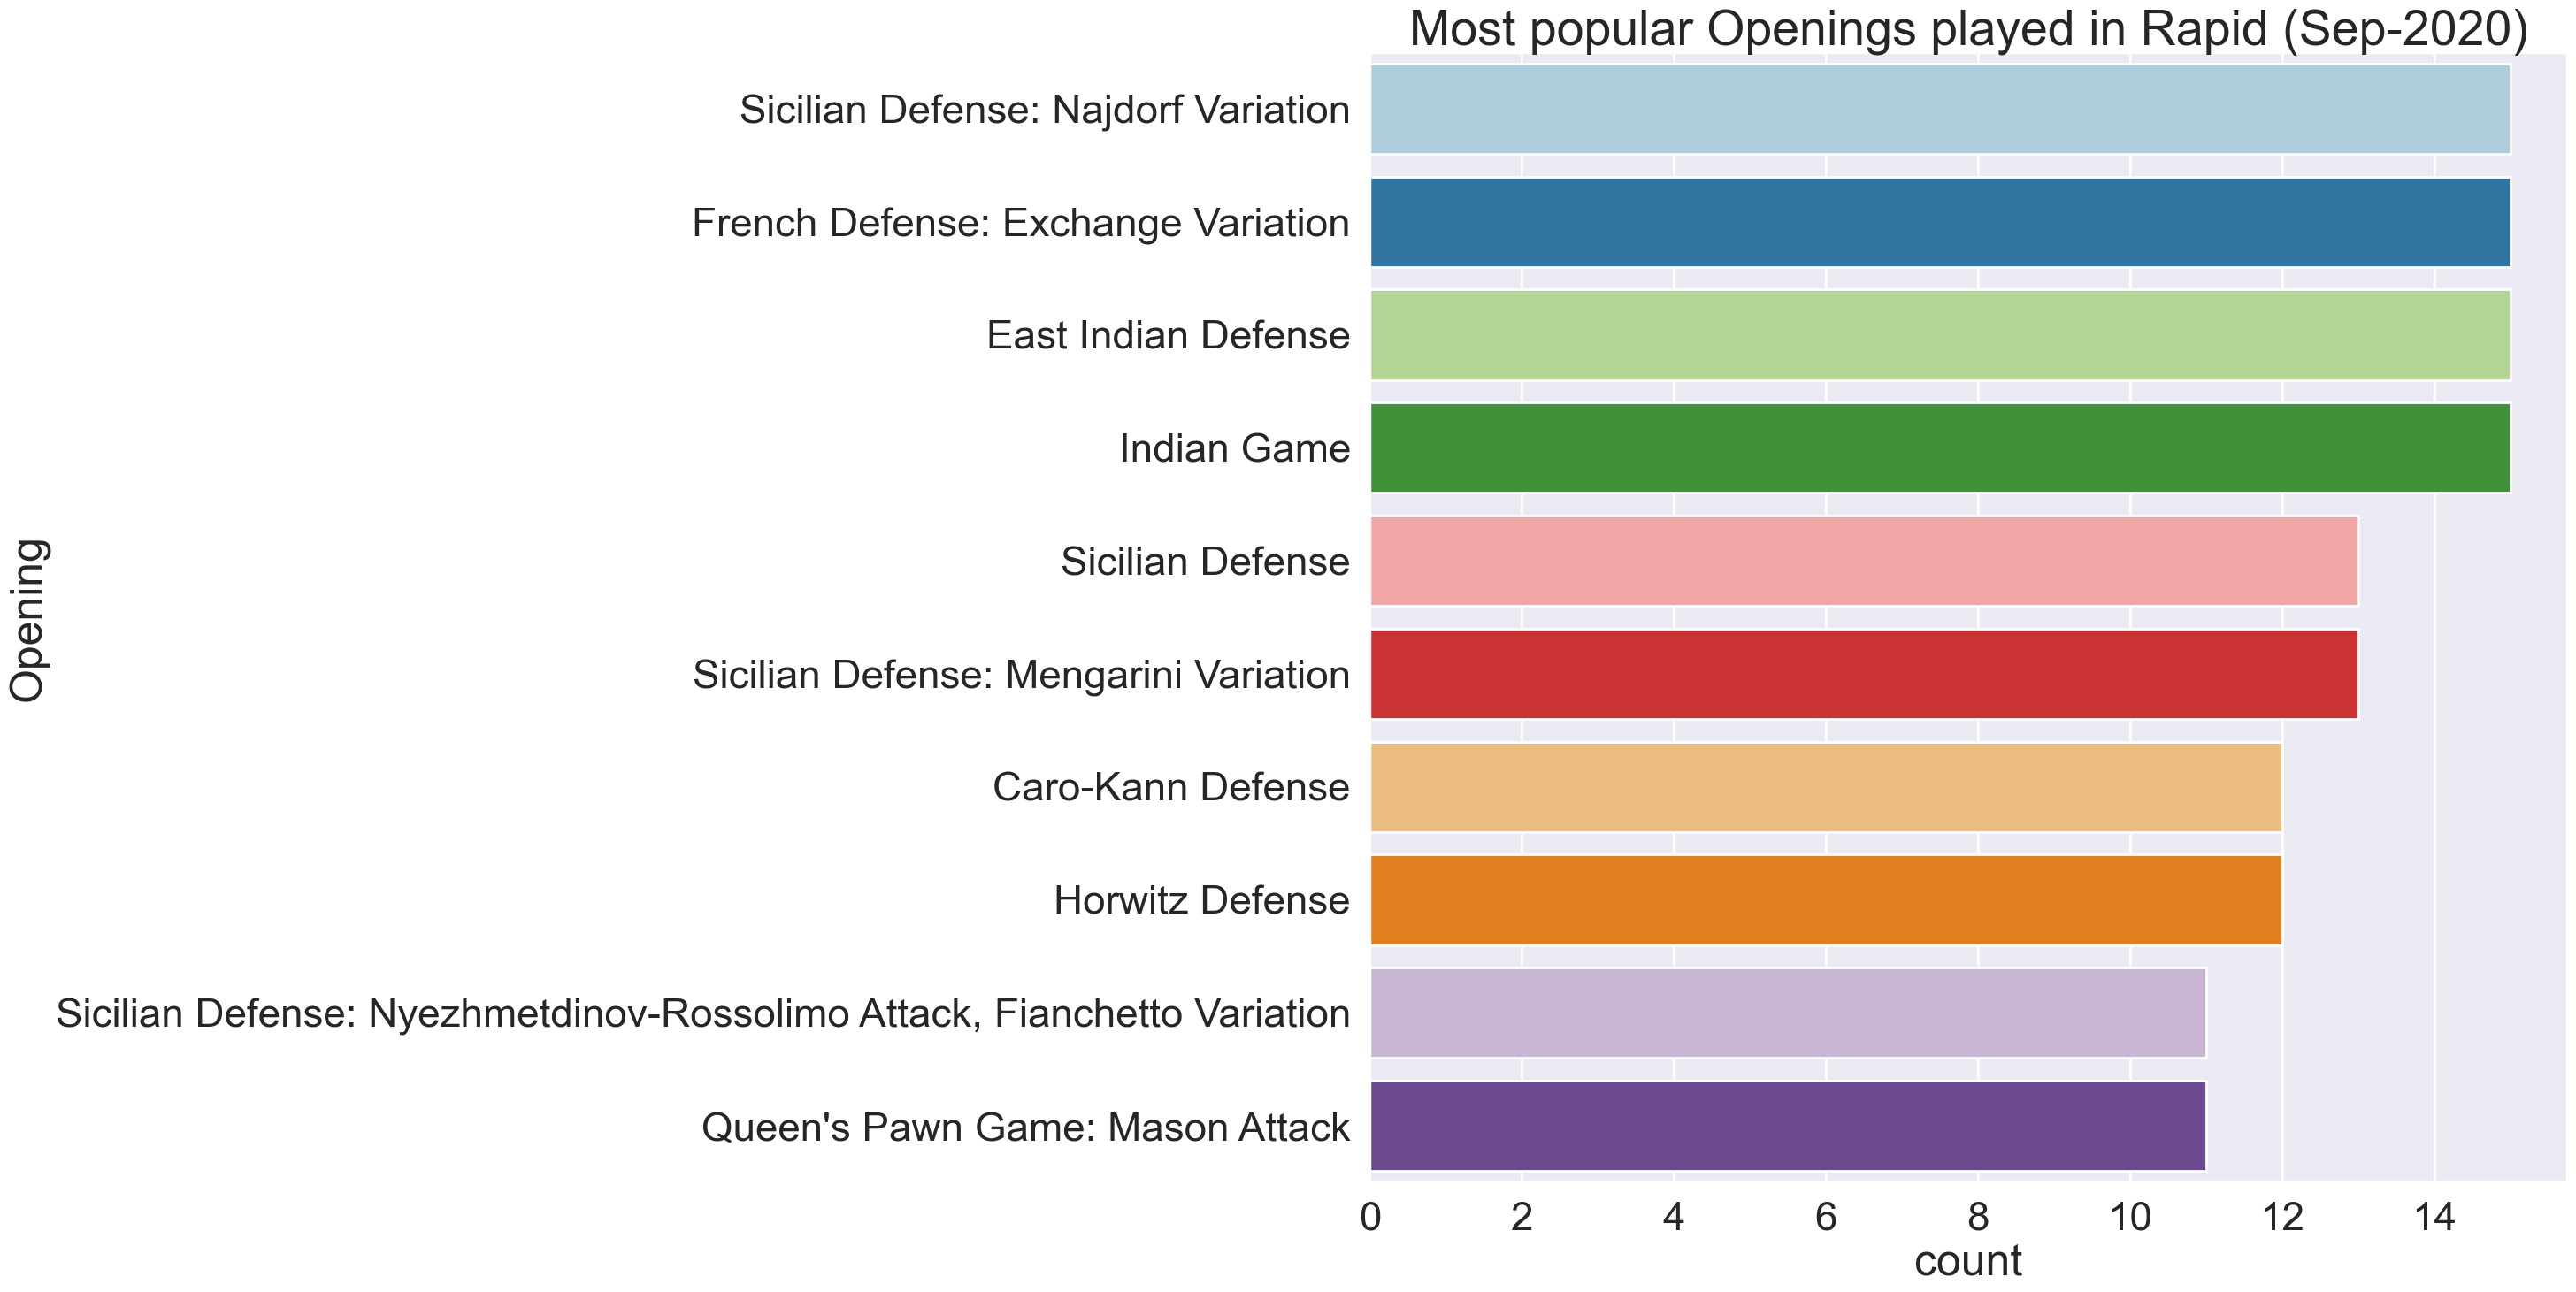

In [101]:
# Create a new DataFrame with the top 10 most frequently occurring openings in rapid games
top10_rapid_openings = df.filter(df['Event'] == 'Rated Rapid game').groupBy('Opening').count().orderBy(desc('count')).limit(10)

# Create a bar plot of the top 10 most frequently occurring openings in rapid games
rapid10 = top10_rapid_openings.toPandas()
plt.figure(figsize=(30,15))
sns.set_context('poster',font_scale=1.5)
sns.barplot(y="Opening",x="count", data=rapid10)
plt.tight_layout()
plt.title("Most popular Openings played in Rapid (Sep-2020)", fontsize=40)

Text(0.5, 1.0, 'Most popular Openings played in Classical (Sep-2020)')

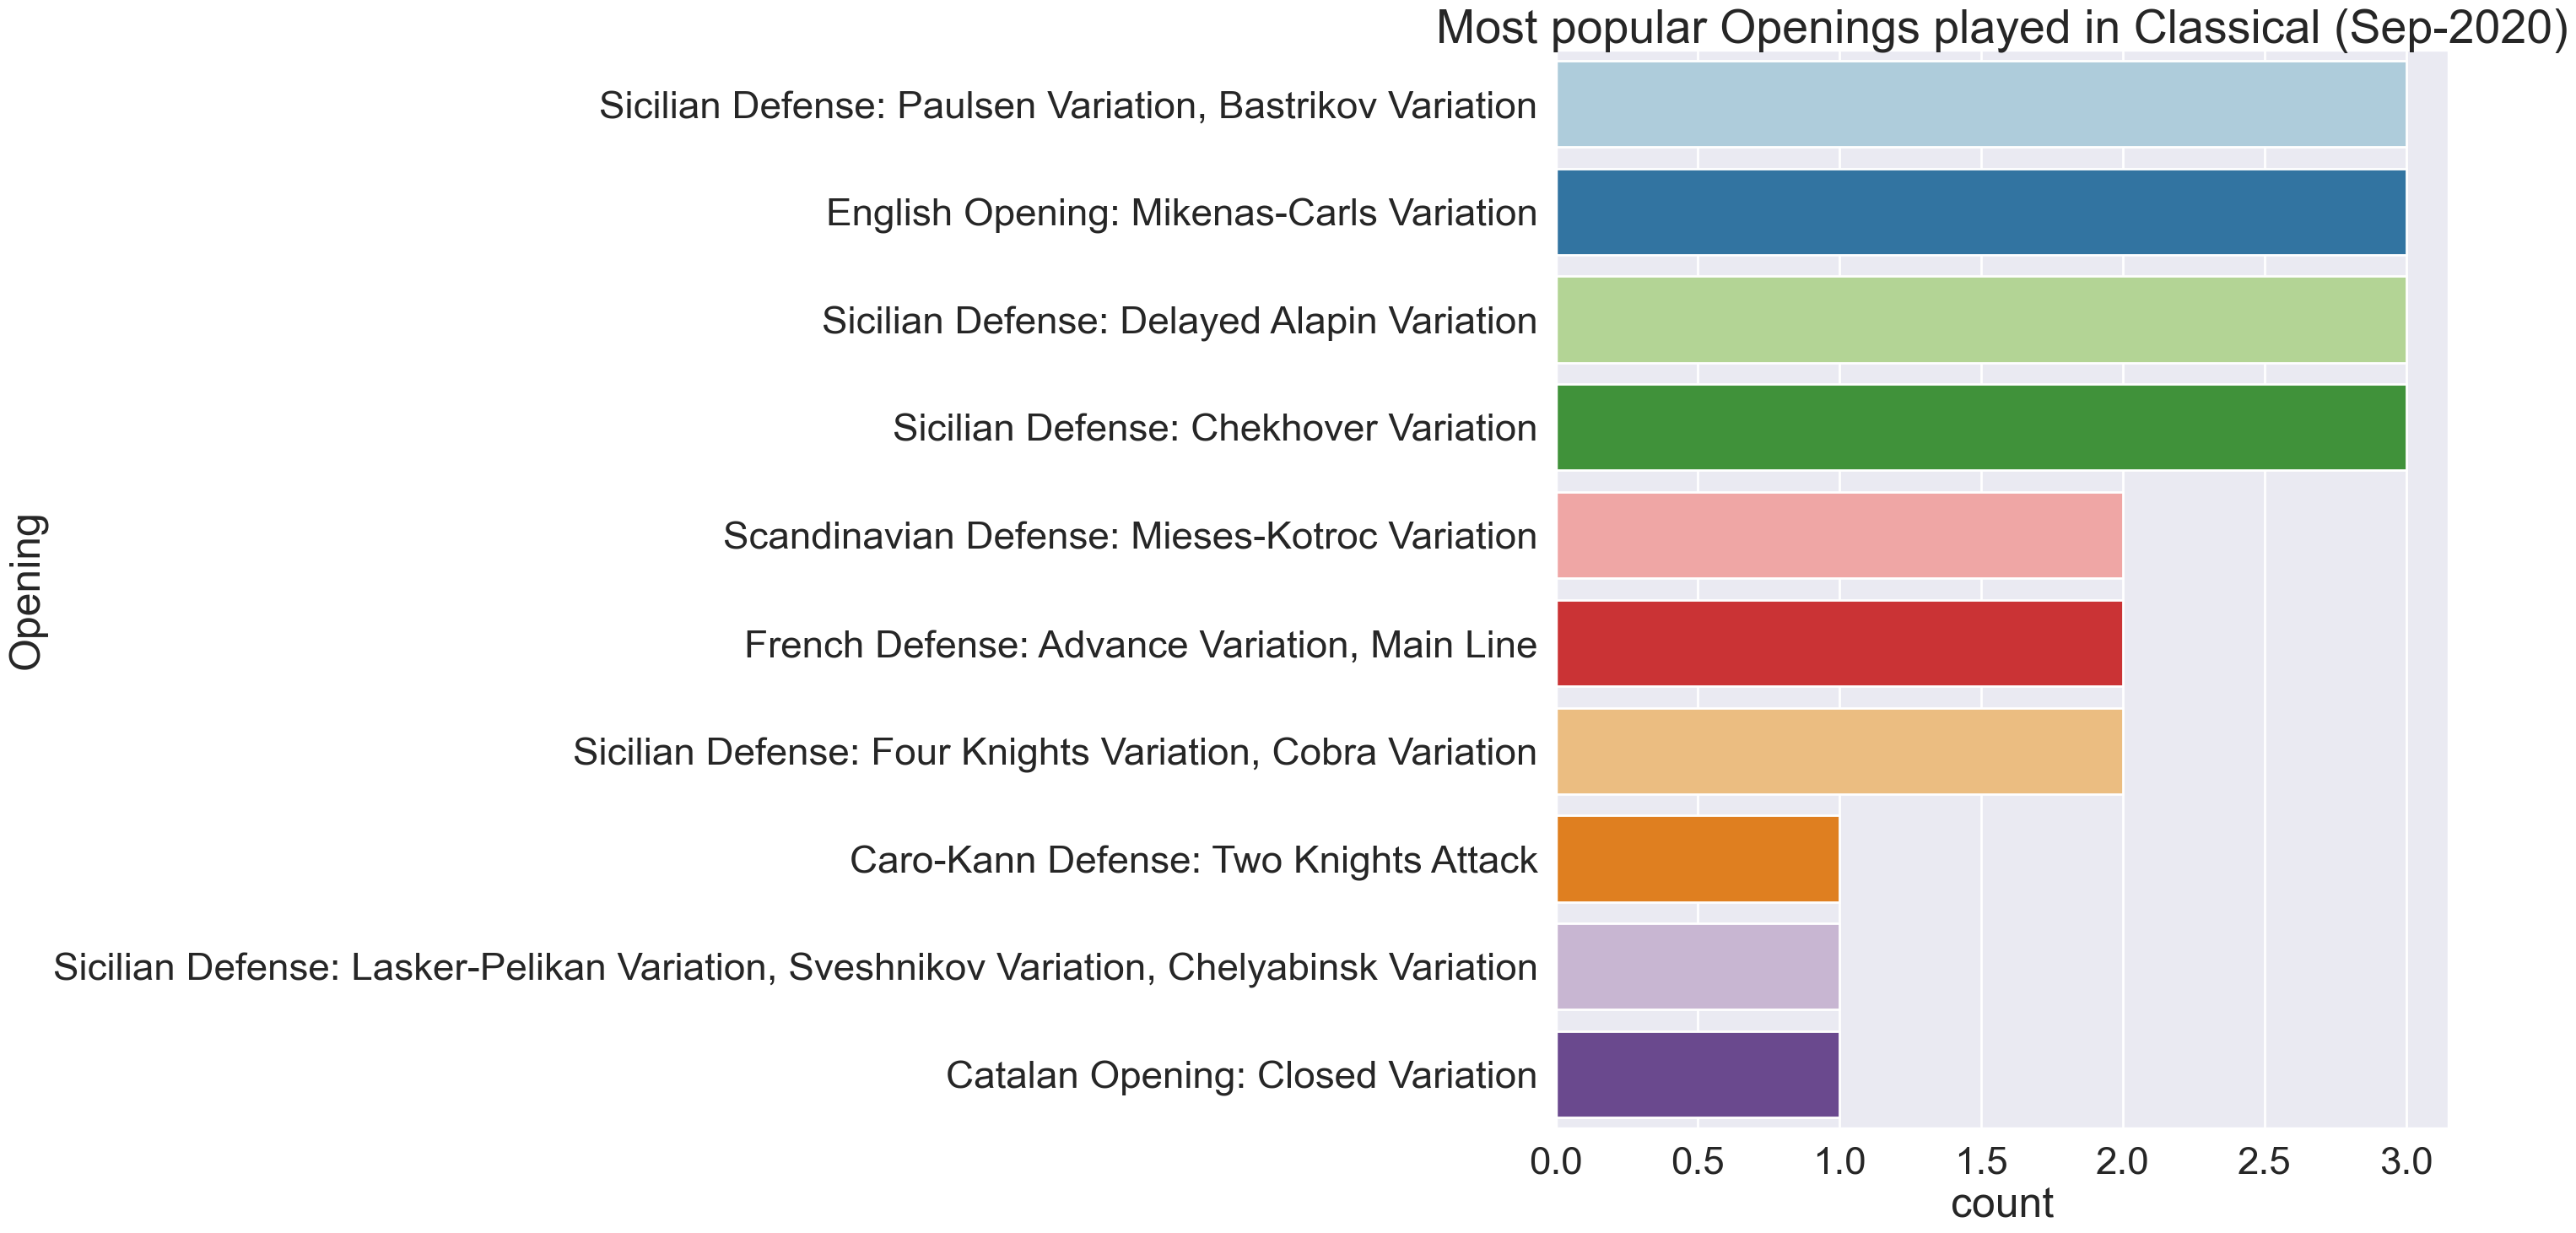

In [102]:
# Create a new DataFrame with the top 10 most frequently occurring openings in classical games
top10_classical_openings = df.filter(df['Event'] == 'Rated Classical game').groupBy('Opening').count().orderBy(desc('count')).limit(10)

# Create a bar plot of the top 10 most frequently occurring openings in classical games
classical10 = top10_classical_openings.toPandas()
plt.figure(figsize=(30,15))
sns.set_context('poster',font_scale=1.5)
sns.barplot(y="Opening",x="count", data=classical10)
plt.tight_layout()
plt.title("Most popular Openings played in Classical (Sep-2020)", fontsize=40)

Indian Game is popular in the first three events’ top 10. The Sicilian Defense strategies are also popular in all three events.

In [103]:
df.groupby(['Result']).count().show()

+-------+-----+
| Result|count|
+-------+-----+
|1/2-1/2|10023|
|    1-0|47245|
|    0-1|42645|
+-------+-----+



In [104]:
# Count the number of wins by each player
w_count = df.groupBy(['Winner']).count()
w_count.show()

+------+-----+
|Winner|count|
+------+-----+
|  Draw|10023|
| White|47245|
| Black|42645|
+------+-----+



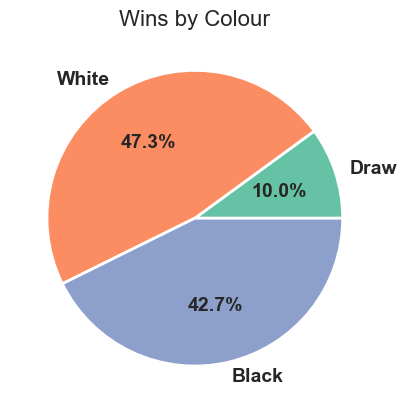

None

In [105]:
# Create a customized pie chart
plt.pie(w_count.toPandas()['count'], labels=w_count.toPandas()['Winner'], autopct='%1.1f%%', colors=plt.cm.Set2.colors, textprops={'fontsize': 14, 'weight': 'bold'})
plt.title('Wins by Colour', fontsize=16)

# Show the plot
display(plt.show())

White and black have close winning percentages while a draw is more rare.

White might have the highest win percentage due to the advantage of starting first in the match. However, based on the history of chess, it became custom and later a rule for white to move first since black was assumed the lucky color. It was then claimed that it would be too advantageous for a player to have the lucky color (black) and move first. 

In [106]:
# Count the number of wins by each player separately
white_wins = df.filter(df['Winner']=='White').groupBy('White').count()
white_wins.show()

+----------------+-----+
|           White|count|
+----------------+-----+
|juancruzariasTDF|   10|
|       IvicKlasa|    2|
|         Oplarex|    3|
|        Takacsbl|   11|
|          tillis|    2|
|      PetrNeuman|   11|
|     ice2breaker|   10|
|       damigamer|    1|
|         carguru|    9|
|         dannkor|    5|
|       Alisson04|    3|
|           DMKey|   31|
|        Coronica|    5|
|       akhilanem|    2|
|      mikhail086|    5|
|       Luchshiy1|    5|
|        Alexkous|   93|
|          zmeeed|    4|
|        NoMate4u|    1|
|        Latiza82|    7|
+----------------+-----+
only showing top 20 rows



In [107]:
black_wins = df.filter(df['Winner']=='Black').groupBy('Black').count()
black_wins.show()

+----------------+-----+
|           Black|count|
+----------------+-----+
|juancruzariasTDF|    7|
|          j_coca|    1|
|        baapaaya|    1|
|       IvicKlasa|    1|
|         Oplarex|    2|
|        Takacsbl|    6|
|        Tango666|    1|
|          tillis|    3|
|      PetrNeuman|    9|
|     ice2breaker|   12|
|    Pommes_Fritz|    1|
|         carguru|    9|
|         Steed28|   45|
|       Alisson04|    2|
|        Coronica|    5|
|           DMKey|   35|
|         dannkor|    6|
|      mikhail086|    2|
|       Luchshiy1|    2|
|        Alexkous|   85|
+----------------+-----+
only showing top 20 rows



In [108]:
# Create DataFrames with the number of wins for each player
w_value_counts = white_wins.withColumnRenamed('White', 'Player').withColumnRenamed('count', 'White Wins')
w_value_counts.show()

+----------------+----------+
|          Player|White Wins|
+----------------+----------+
|juancruzariasTDF|        10|
|       IvicKlasa|         2|
|         Oplarex|         3|
|        Takacsbl|        11|
|          tillis|         2|
|      PetrNeuman|        11|
|     ice2breaker|        10|
|       damigamer|         1|
|         carguru|         9|
|         dannkor|         5|
|       Alisson04|         3|
|           DMKey|        31|
|        Coronica|         5|
|       akhilanem|         2|
|      mikhail086|         5|
|       Luchshiy1|         5|
|        Alexkous|        93|
|          zmeeed|         4|
|        NoMate4u|         1|
|        Latiza82|         7|
+----------------+----------+
only showing top 20 rows



In [109]:
b_value_counts = black_wins.withColumnRenamed('Black', 'Player').withColumnRenamed('count', 'Black Wins')
b_value_counts.show()

+----------------+----------+
|          Player|Black Wins|
+----------------+----------+
|juancruzariasTDF|         7|
|          j_coca|         1|
|        baapaaya|         1|
|       IvicKlasa|         1|
|         Oplarex|         2|
|        Takacsbl|         6|
|        Tango666|         1|
|          tillis|         3|
|      PetrNeuman|         9|
|     ice2breaker|        12|
|    Pommes_Fritz|         1|
|         carguru|         9|
|         Steed28|        45|
|       Alisson04|         2|
|        Coronica|         5|
|           DMKey|        35|
|         dannkor|         6|
|      mikhail086|         2|
|       Luchshiy1|         2|
|        Alexkous|        85|
+----------------+----------+
only showing top 20 rows



In [110]:
# Import necessary libraries
import pyspark.sql.functions as F

# Combine the data frames based on matching columns
merged_df = w_value_counts.join(b_value_counts, on='Player', how='inner')

# Add a new column 'Wins' to the merged DataFrame
merged_df = merged_df.withColumn('Total Wins', F.col('White Wins') + F.col('Black Wins'))

# Display the schema of the merged DataFrame
merged_df.printSchema()

root
 |-- Player: string (nullable = true)
 |-- White Wins: long (nullable = false)
 |-- Black Wins: long (nullable = false)
 |-- Total Wins: long (nullable = false)



In [111]:
# Display the merged DataFrame
merged_df.show()

+-------------------+----------+----------+----------+
|             Player|White Wins|Black Wins|Total Wins|
+-------------------+----------+----------+----------+
|   juancruzariasTDF|        10|         7|        17|
|           baapaaya|         1|         1|         2|
|          IvicKlasa|         2|         1|         3|
|            Oplarex|         3|         2|         5|
|           Takacsbl|        11|         6|        17|
|             tillis|         2|         3|         5|
|         PetrNeuman|        11|         9|        20|
|        ice2breaker|        10|        12|        22|
|            carguru|         9|         9|        18|
|            Steed28|        45|        45|        90|
|          Alisson04|         3|         2|         5|
|           Coronica|         5|         5|        10|
|              DMKey|        31|        35|        66|
|            dannkor|         5|         6|        11|
|         mikhail086|         5|         2|         7|
|         

In [112]:
# Sort the DataFrame in descending order based on a specific column
merged_df = merged_df.orderBy(F.col('Total Wins').desc())
merged_df.show()

+--------------------+----------+----------+----------+
|              Player|White Wins|Black Wins|Total Wins|
+--------------------+----------+----------+----------+
|       Machinegunusa|       124|       113|       237|
|                ljdr|       116|       108|       224|
|        Gettingold72|       113|       106|       219|
|            Neftegor|       110|        94|       204|
|            elveneno|        94|        96|       190|
|              GABROF|        92|        92|       184|
|        ElAdversario|        97|        86|       183|
|              mixo23|        94|        87|       181|
|          Belsychess|        90|        89|       179|
|            Alexkous|        93|        85|       178|
|           Bastiphil|        91|        83|       174|
|   JesusFrankenstein|        76|        95|       171|
|             Cherone|        84|        87|       171|
|             kintoho|        74|        88|       162|
|              Dr-CRO|        82|        79|    

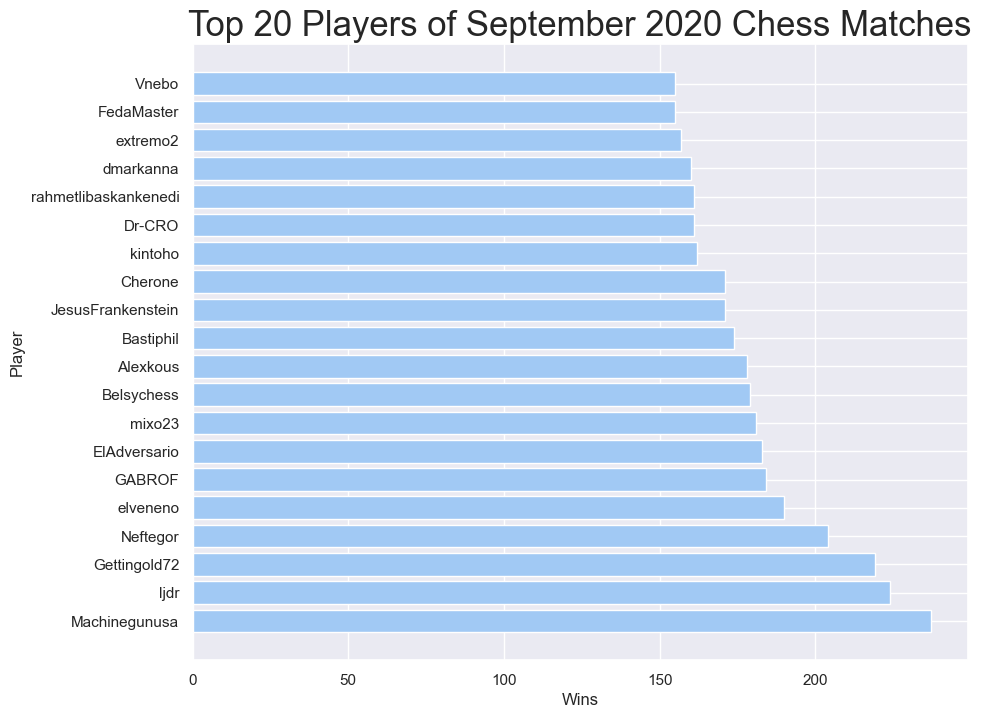

In [113]:
# Create a new DataFrame with the top 20 most frequently occurring openings
top20 = merged_df.select('Player', 'Total Wins').orderBy(F.desc('Total Wins')).limit(20)

# Convert the DataFrame to a Pandas DataFrame
top20_pd = top20.toPandas()

# Plot the top 20 items using a horizontal bar chart
sns.set(font_scale=1)
sns.set_palette('pastel')
plt.figure(figsize=(10, 8))
plt.barh(top20_pd['Player'], top20_pd['Total Wins'])

# Add labels and title to the plot
plt.xlabel('Wins')
plt.ylabel('Player')
plt.title('Top 20 Players of September 2020 Chess Matches', fontsize=25)

# Display the plot
plt.show()

The top three players are Machinegunusa, ljdr, Gettingold72.

In [114]:
# Count the values in the 'Termination' column where 'Opening' is equal to 'Indian Game'
df.filter(df['Opening'] == 'Indian Game').groupBy('Termination').count().show()

+------------+-----+
| Termination|count|
+------------+-----+
|Time forfeit|  404|
|      Normal| 1306|
+------------+-----+



In [121]:
# Create a new DataFrame with the count of each unique value in the 'Termination' column
termin_count = df.groupBy('Termination').count()
termin_count.show()

+----------------+-----+
|     Termination|count|
+----------------+-----+
|       Abandoned|  155|
|    Time forfeit|21699|
|          Normal|78057|
|Rules infraction|    2|
+----------------+-----+



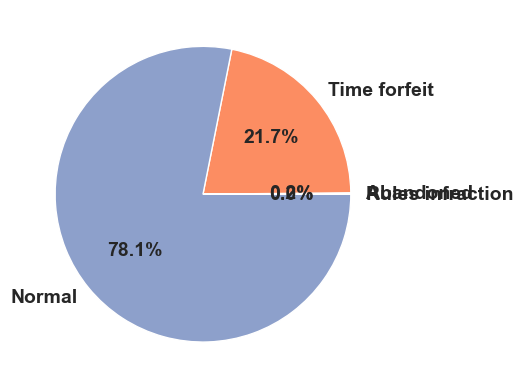

In [122]:
# Create a pie chart of the 'Termination' column
fig, ax = plt.subplots()
ax.pie(termin_count.toPandas()['count'], labels=termin_count.toPandas()['Termination'], autopct='%1.1f%%', colors=plt.cm.Set2.colors, textprops={'fontsize': 14, 'weight': 'bold'})

# Show the plot
plt.show()

Most players won by finishing the match as by normal playing methods whereas rules infraction was very rare. But how do these wins or losses get triggered and are they dependant on the opening move of the match? 

In [123]:
# Count the number of occurrences of each unique value in the 'Opening' column where 'Termination' is equal to 'Time forfeit'
df.filter(df['Termination'] == 'Time forfeit').groupBy('Opening').count().desc().show()

+--------------------+-----+
|             Opening|count|
+--------------------+-----+
|Grünfeld Defense:...|   46|
|Caro-Kann Defense...|    5|
|Queen's Gambit Ac...|    8|
|Alekhine Defense:...|    4|
|King's Indian Att...|   19|
|Slav Defense: Cze...|    5|
|Four Knights Game...|    2|
|Blackmar-Diemer G...|    2|
|French Defense: S...|   41|
|King's Indian Def...|    7|
|French Defense: C...|   45|
|Grünfeld Defense:...|    1|
|Four Knights Game...|    1|
|Queen's Gambit De...|    5|
|English Opening: ...|    3|
|Benoni Defense: C...|    2|
|Scotch Game: Mala...|    2|
|Slav Defense: Exc...|   11|
|  St. George Defense|   29|
|Nimzo-Larsen Atta...|   12|
+--------------------+-----+
only showing top 20 rows



In [124]:
# Count the number of occurrences of each unique value in the 'Opening' column where 'Termination' is equal to 'Abandoned'
df.filter(df['Termination'] == 'Abandoned').groupBy('Opening').count().desc().show()

+--------------------+-----+
|             Opening|count|
+--------------------+-----+
|         King's Pawn|   32|
|        Réti Opening|   12|
|                   ?|   88|
|        Queen's Pawn|   20|
|     English Opening|    2|
|Van't Kruijs Opening|    1|
+--------------------+-----+



In [125]:
# Count the number of occurrences of each unique value in the 'Opening' column where 'Termination' is equal to 'Rules Infraction'
df.filter(df['Termination'] == 'Rules infraction').groupBy('Opening').count().show()

+--------------------+-----+
|             Opening|count|
+--------------------+-----+
|Sicilian Defense:...|    1|
|Slav Defense: Modern|    1|
+--------------------+-----+



In [126]:
# Count the number of occurrences of each unique value in the 'Opening' column where 'Winner' is equal to 'White'
df.filter(df['Winner'] == 'White').groupBy('Opening').count().desc().show()

+--------------------+-----+
|             Opening|count|
+--------------------+-----+
|Alekhine Defense:...|   12|
|King's Indian Att...|   40|
|Grünfeld Defense:...|   77|
|Caro-Kann Defense...|   11|
|Queen's Gambit Ac...|   13|
|Slav Defense: Cze...|    7|
|King's Gambit, Fa...|    2|
|Queen's Gambit De...|    4|
|Ruy Lopez: Classi...|    2|
|Owen Defense: Mat...|    5|
|Blackmar-Diemer G...|    1|
|French Defense: S...|   83|
|French Defense: C...|  107|
|Sicilian Defense:...|    4|
|King's Indian Def...|   19|
|Four Knights Game...|    5|
|Tarrasch Defense:...|    3|
|Queen's Gambit De...|    7|
|Tarrasch Defense:...|    1|
|Slav Defense: Exc...|   22|
+--------------------+-----+
only showing top 20 rows



In [127]:
# Count the number of occurrences of each unique value in the 'Opening' column where 'Winner' is equal to 'Black'
df.filter(df['Winner'] == 'Black').groupBy('Opening').count().desc().show()

+--------------------+-----+
|             Opening|count|
+--------------------+-----+
|Ruy Lopez: Classi...|    1|
|Slav Defense: Cze...|    8|
|Grünfeld Defense:...|   82|
|King's Indian Att...|   49|
|Tarrasch Defense:...|    3|
|Italian Game: Two...|    1|
|Queen's Gambit De...|    1|
|Alekhine Defense:...|    5|
|Queen's Gambit Ac...|   15|
|King's Indian Def...|    4|
|Four Knights Game...|    5|
|Owen Defense: Mat...|    7|
|Caro-Kann Defense...|    5|
|Blackmar-Diemer G...|    1|
|Grünfeld Defense:...|   13|
|King's Indian Def...|    8|
|French Defense: S...|   86|
|French Defense: C...|   77|
|Grünfeld Defense:...|    6|
|Grünfeld Defense:...|    1|
+--------------------+-----+
only showing top 20 rows



In [128]:
# Count the number of occurrences of each unique value in the 'Opening' column where 'Winner' is equal to 'Draw'
df.filter(df['Winner'] == 'Draw').groupBy('Opening').count().desc().show()

+--------------------+-----+
|             Opening|count|
+--------------------+-----+
|King's Indian Att...|    6|
|Slav Defense: Cze...|    3|
|Grünfeld Defense:...|   19|
|Queen's Gambit Ac...|    6|
|French Defense: S...|   13|
|King's Indian Def...|    2|
|French Defense: C...|   20|
|Four Knights Game...|    1|
|Tarrasch Defense:...|    2|
|  St. George Defense|    7|
|Slav Defense: Exc...|   13|
|Nimzo-Larsen Atta...|    4|
|Benoni Defense: C...|    2|
|Scotch Game: Mala...|    4|
|Modern Defense: S...|   31|
|Scotch Game: Mies...|   18|
|Nimzo-Indian Defe...|    5|
|King's Indian Def...|    5|
|King's Indian Def...|    1|
|English Opening: ...|    4|
+--------------------+-----+
only showing top 20 rows



Winning chances may be influenced by the Opening but there is not enough information to confirm.

### Data Preparation
The main purposes of data preparation is to ensure that raw data being prepared for processing and analysis is accurate and consistent so that the results are valid. In this section, a dataframe prepared containing the main analysis features. This dataframe is prepared in order for models to analyse them.

In [129]:
# Create a new DataFrame with the desired columns
ana_df = df.select('Event', 'White', 'Black', 'BlackElo', 'ECO', 'Opening', 'Termination', 'TimeControl', 'WhiteElo', 'WhiteRatingDiff', 'Winner')

# Create a new column 'Winner' with values 1 if the winner is White, 0 otherwise
ana_df = ana_df.withColumn('Winner', F.when(F.col('Winner') == 'White', 1).otherwise(0))

In [130]:
pd.DataFrame(ana_df.take(5), columns=ana_df.columns).transpose()

,0,1,2,3,4
Event,Rated Blitz tournament https://lichess.org/tou...,Rated Blitz game,Rated Rapid tournament https://lichess.org/tou...,Rated Blitz tournament https://lichess.org/tou...,Rated Blitz game
White,AttackSparrow,onthewaygm,OjaiJoao,WenceslaoRodrigo,HoldenHc
Black,danicuva,starkspieler,FitzwilliamDarcy,zonrobla,gg-gm-gmg
BlackElo,2218,2424,2300,2667,2682
ECO,C00,E90,B06,E71,A41
Opening,French Defense: Schlechter Variation,"King's Indian Defense: Normal Variation, Rare ...",Modern Defense: Standard Defense,King's Indian Defense: Makogonov Variation,Queen's Pawn
Termination,Time forfeit,Normal,Normal,Normal,Normal
TimeControl,180+0,180+0,600+5,180+1,180+0
WhiteElo,2460,2428,2441,2280,2557
WhiteRatingDiff,2,6,5,-2,8


In [131]:
ana_df = ana_df.select('BlackElo', 'ECO', 'Opening', 'TimeControl', 'WhiteElo', 'WhiteRatingDiff', 'Winner')
ana_df.printSchema()

root
 |-- BlackElo: integer (nullable = true)
 |-- ECO: string (nullable = true)
 |-- Opening: string (nullable = true)
 |-- TimeControl: string (nullable = true)
 |-- WhiteElo: integer (nullable = true)
 |-- WhiteRatingDiff: integer (nullable = true)
 |-- Winner: integer (nullable = false)



In [132]:
cols = ana_df.columns

For feature encoding, OneHotEncoder, StringIndexer and VectorAssembler is used.

A DataFrame's category string columns can be converted into numerical indexes with the support of the StringIndexer. Most machine learning algorithms cannot deal directly with string data, hence this translation is required.

Since categorical features are transformed into dummy features, one-hot encoding is also known as dummy encoding. One or more categorical characteristics can be converted into numerical dummy features that are helpful for training machine learning models using one-hot encoding. 

VectorIndexer facilitates the indexing of categorical characteristics within vector datasets. It is capable of converting original values to category indices and automatically determining which features are categorical.

In [133]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

stages = []
categoricalColumns = ['ECO', 'Opening', 'TimeControl']

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(
        inputCols=[stringIndexer.getOutputCol()], 
        outputCols=[categoricalCol + "classVec"]
    )
    stages += [stringIndexer, encoder]
    
label_stringIdx = StringIndexer(inputCol = 'Winner', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['BlackElo','WhiteElo']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [134]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(ana_df)
ana_df = pipelineModel.transform(ana_df)
selectedCols = ['label', 'features'] + cols
ana_df = ana_df.select(selectedCols)

ana_df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- BlackElo: integer (nullable = true)
 |-- ECO: string (nullable = true)
 |-- Opening: string (nullable = true)
 |-- TimeControl: string (nullable = true)
 |-- WhiteElo: integer (nullable = true)
 |-- WhiteRatingDiff: integer (nullable = true)
 |-- Winner: integer (nullable = false)



In [135]:
pdf = pd.DataFrame(ana_df.take(5), columns=ana_df.columns)
pdf.iloc[:,0:2] 

,label,features
0,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
3,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [136]:
len(pdf.features[0])

2743

### Split dataset

In [137]:
train, test = ana_df.randomSplit([0.7, 0.3], seed = 1234)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 69817
Test Dataset Count: 30096


With our train and test set, multiple models are built and compared to provide the best prediction accuracy.

### Logistic Regression Model

In [138]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=100)
lrModel = lr.fit(train)

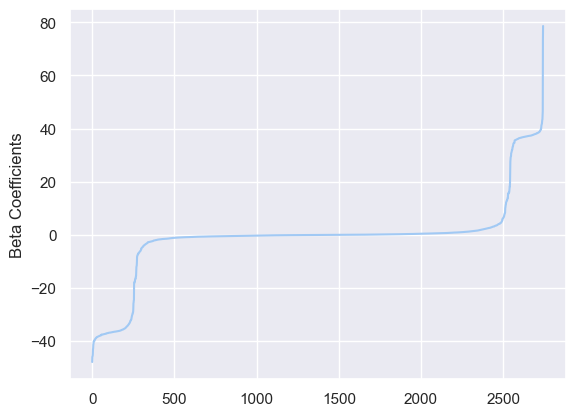

In [139]:
import numpy as np

beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

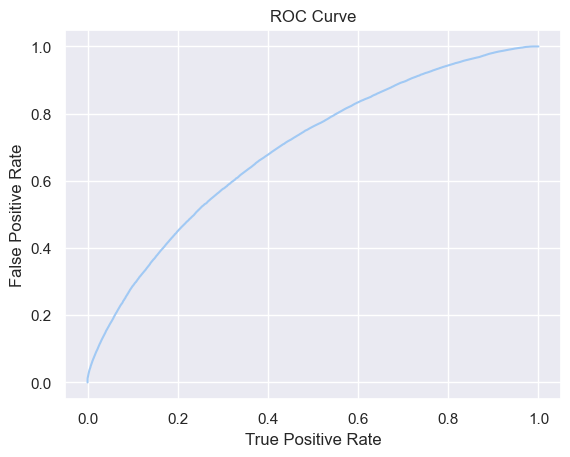

Training set areaUnderROC: 0.6942760315126474


In [140]:
trainingSummary = lrModel.summary
lrROC = trainingSummary.roc.toPandas()

plt.plot(lrROC['FPR'],lrROC['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

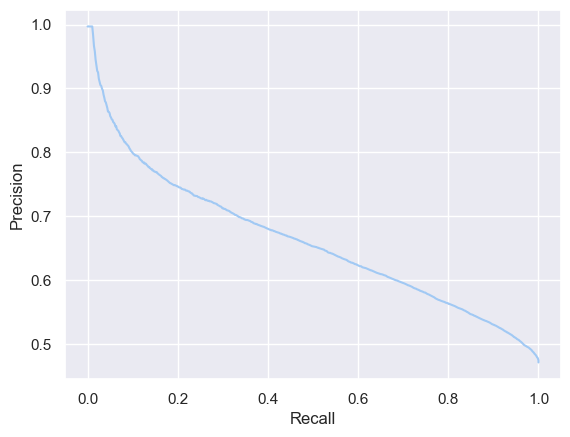

In [141]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [142]:
lrPreds = lrModel.transform(test)
lrPreds.select('BlackElo', 'WhiteElo', 'WhiteRatingDiff', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+--------+--------+---------------+-----+--------------------+----------+--------------------+
|BlackElo|WhiteElo|WhiteRatingDiff|label|       rawPrediction|prediction|         probability|
+--------+--------+---------------+-----+--------------------+----------+--------------------+
|    2200|    2530|             -4|  0.0|[-1.5872485561885...|       1.0|[0.16977135801517...|
|    2215|    2417|             -9|  0.0|[-0.9298652692225...|       1.0|[0.28295204926028...|
|    2272|    2423|             -9|  0.0|[-0.6607631855020...|       1.0|[0.34056819335536...|
|    2336|    2446|             -7|  0.0|[-0.4418698795254...|       1.0|[0.39129550469911...|
|    2350|    2421|             -7|  0.0|[-0.2402472191239...|       1.0|[0.44022542836564...|
|    2356|    2405|             -7|  0.0|[-0.1267782145743...|       1.0|[0.46834782969864...|
|    2360|    2419|             -7|  0.0|[-0.1774089119696...|       1.0|[0.45576373525330...|
|    2360|    2422|             -7|  0.0|[-0.19276

In [143]:
lrPreds.show()

+-----+--------------------+--------+---+-----------+-----------+--------+---------------+------+--------------------+--------------------+----------+
|label|            features|BlackElo|ECO|    Opening|TimeControl|WhiteElo|WhiteRatingDiff|Winner|       rawPrediction|         probability|prediction|
+-----+--------------------+--------+---+-----------+-----------+--------+---------------+------+--------------------+--------------------+----------+
|  0.0|(2743,[0,491,2680...|    2200|A45|Indian Game|      180+0|    2530|             -4|     0|[-1.5872485561885...|[0.16977135801517...|       1.0|
|  0.0|(2743,[0,491,2680...|    2215|A45|Indian Game|      180+0|    2417|             -9|     0|[-0.9298652692225...|[0.28295204926028...|       1.0|
|  0.0|(2743,[0,491,2680...|    2272|A45|Indian Game|      180+0|    2423|             -9|     0|[-0.6607631855020...|[0.34056819335536...|       1.0|
|  0.0|(2743,[0,491,2680...|    2336|A45|Indian Game|      180+0|    2446|             -7|    

#### Evaluate the Logistic Regression model

In [144]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lrEval = BinaryClassificationEvaluator()
print('Test Area Under ROC', lrEval.evaluate(lrPreds))

Test Area Under ROC 0.652019198980303


However, it is suggestable to explore a few other models before deciding that the logistic regression model is the optimal model to make predictions for this dataset.

### Decision Tree Classifier

In [145]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)

In [146]:
dtPreds = dtModel.transform(test)
dtPreds.select('BlackElo', 'WhiteElo', 'WhiteRatingDiff', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+--------+--------+---------------+-----+----------------+----------+--------------------+
|BlackElo|WhiteElo|WhiteRatingDiff|label|   rawPrediction|prediction|         probability|
+--------+--------+---------------+-----+----------------+----------+--------------------+
|    2200|    2530|             -4|  0.0|[7315.0,12072.0]|       1.0|[0.37731469541445...|
|    2215|    2417|             -9|  0.0|[7315.0,12072.0]|       1.0|[0.37731469541445...|
|    2272|    2423|             -9|  0.0|[7315.0,12072.0]|       1.0|[0.37731469541445...|
|    2336|    2446|             -7|  0.0|[7315.0,12072.0]|       1.0|[0.37731469541445...|
|    2350|    2421|             -7|  0.0|[7315.0,12072.0]|       1.0|[0.37731469541445...|
|    2356|    2405|             -7|  0.0|[7315.0,12072.0]|       1.0|[0.37731469541445...|
|    2360|    2419|             -7|  0.0|[7315.0,12072.0]|       1.0|[0.37731469541445...|
|    2360|    2422|             -7|  0.0|[7315.0,12072.0]|       1.0|[0.37731469541445...|

#### Evaluate the Decision Tree model

In [147]:
dtEval = BinaryClassificationEvaluator()
dtROC = dtEval.evaluate(dtPreds, {dtEval.metricName: "areaUnderROC"})
print("Test Area Under ROC: " + str(dtROC))

Test Area Under ROC: 0.6186391605203818


### Random Forest Classifier

In [148]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)

In [149]:
rfPreds = rfModel.transform(test)
rfPreds.select('BlackElo', 'WhiteElo', 'WhiteRatingDiff', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+--------+--------+---------------+-----+--------------------+----------+--------------------+
|BlackElo|WhiteElo|WhiteRatingDiff|label|       rawPrediction|prediction|         probability|
+--------+--------+---------------+-----+--------------------+----------+--------------------+
|    2200|    2530|             -4|  0.0|[10.2097183093221...|       0.0|[0.51048591546610...|
|    2215|    2417|             -9|  0.0|[10.2097183093221...|       0.0|[0.51048591546610...|
|    2272|    2423|             -9|  0.0|[10.2097183093221...|       0.0|[0.51048591546610...|
|    2336|    2446|             -7|  0.0|[10.2097183093221...|       0.0|[0.51048591546610...|
|    2350|    2421|             -7|  0.0|[10.2097183093221...|       0.0|[0.51048591546610...|
|    2356|    2405|             -7|  0.0|[10.2097183093221...|       0.0|[0.51048591546610...|
|    2360|    2419|             -7|  0.0|[10.2097183093221...|       0.0|[0.51048591546610...|
|    2360|    2422|             -7|  0.0|[10.20971

#### Evaluate the Random Forest Classifier

In [150]:
rfEval = BinaryClassificationEvaluator()
rfROC = rfEval.evaluate(rfPreds, {rfEval.metricName: "areaUnderROC"})
print("Test Area Under ROC: " + str(rfROC))

Test Area Under ROC: 0.6264676598089398


### Gradient-Boosted Tree Classifier

In [151]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=100)
gbtModel = gbt.fit(train)

In [152]:
gbtPreds = gbtModel.transform(test)
gbtPreds.select('BlackElo', 'WhiteElo', 'WhiteRatingDiff', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+--------+--------+---------------+-----+--------------------+----------+--------------------+
|BlackElo|WhiteElo|WhiteRatingDiff|label|       rawPrediction|prediction|         probability|
+--------+--------+---------------+-----+--------------------+----------+--------------------+
|    2200|    2530|             -4|  0.0|[-0.7075102554343...|       1.0|[0.19544339746909...|
|    2215|    2417|             -9|  0.0|[-0.3680489890923...|       1.0|[0.32385799712098...|
|    2272|    2423|             -9|  0.0|[-0.3504841029396...|       1.0|[0.33159759909137...|
|    2336|    2446|             -7|  0.0|[-0.1037836088063...|       1.0|[0.44829370590537...|
|    2350|    2421|             -7|  0.0|[-0.1037836088063...|       1.0|[0.44829370590537...|
|    2356|    2405|             -7|  0.0|[-0.0037833462130...|       1.0|[0.49810833591903...|
|    2360|    2419|             -7|  0.0|[-0.1037836088063...|       1.0|[0.44829370590537...|
|    2360|    2422|             -7|  0.0|[-0.10378

#### Evaluate the Gradient-Boosted Tree Classifier

In [153]:
gbtEval = BinaryClassificationEvaluator()
gbtROC = gbtEval.evaluate(gbtPreds, {gbtEval.metricName: "areaUnderROC"})
print("Test Area Under ROC: " + str(gbtROC))

Test Area Under ROC: 0.6650772562010534


All models have a test accuracy above 60%. This may not be high enough to confirm reliabiltiy and accuracy of model predictions. Hence the models with the highest test accuracies will be further improved.

The highest scores are from the logistic regression model and gradient-boosted tree classifier. Hence, both these models will be tuned and compare results to select the best one with the highest possible accuracy.

### Logistic Regression - HyperTuning

In [154]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The

In [155]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Define the hyperparameter grid to search over
param_grid = (ParamGridBuilder()
              .addGrid(lr.regParam, [0.01, 0.1])
              .addGrid(lr.elasticNetParam, [0.2, 0.6])
              .build())

# Define the cross-validation object
lcv = CrossValidator(estimator=lr, estimatorParamMaps=param_grid, evaluator=lrEval, numFolds=10)

# Run cross validations.
lcvModel = lcv.fit(train)
lcvPreds = lcvModel.transform(test)

# Evaluate the performance of the model on the testing data
lrEval.evaluate(lcvPreds)

0.6716057481870952

### Gradient-Boosted Tree - HyperTuning

In [156]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [157]:
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=gbtEval, numFolds=5)

# Run cross validations.  
# This can take some minutes since it is training many trees!
cvModel = cv.fit(train)
cvPreds = cvModel.transform(test)
gbtEval.evaluate(cvPreds)

0.6664341523216473

The model accuracy of the models have improved, however there is still more model improvement to be done. Future projects will include more methods to improve model accuracy and gain more insight and support on the logistic regression theory in match prediction.

Once the evalutation process has completed, new predictions can be made. For this section, user input is relied on.

A few rules to provide decent accuracy and avoid crash:
- Use integer values only. 
- Ranking difference is the only value which should have a negative value in the set.
- Do not use alphabet characters
- Do not use special characters

Furthermore, feel free to try it out!

### Make Predictions

In [158]:
new_data = []

In [159]:
# Prompt the user to enter new data
elo_black = input('Enter Player Black Elo Rating: ')

Enter Player Black Elo Rating:  2300


In [160]:
# Prompt the user to enter new data
elo_white = input('Enter Player White Elo Rating: ')

Enter Player White Elo Rating:  2500


In [161]:
# Note that rank difference can be determined from black or white.
# E.g. If rank is -2 from black, then prediction is if black wins or not
RankDiff = input('Enter Rank Difference: ')

Enter Rank Difference:  -2


In [174]:
new_data = [(int(elo_black), int(elo_white), int(RankDiff))]

In [186]:
# Create a new DataFrame with the new data
new_data_df = spark.createDataFrame(new_data, ["elo_black", "elo_white", "RankDiff"])

new_data_df = new_data_df.withColumn("elo_black", col("elo_black").cast("int")).withColumn("elo_white", col("elo_white").cast("int")).withColumn("RankDiff", col("RankDiff").cast("int"))

new_data_df.printSchema()

root
 |-- elo_black: integer (nullable = true)
 |-- elo_white: integer (nullable = true)
 |-- RankDiff: integer (nullable = true)



In [ ]:
# Make predictions on the new data using the best model found by cross-validation
predictions = lcvModel.transform(new_data_df)

# Show the predictions
predictions.show()